# Data Cleaning & Preparation

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(32)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


In [ ]:
# read in the data
fetal = pd.read_csv("https://raw.githubusercontent.com/SamyDahman/MLData/main/fetal_health.csv")
fetal.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [ ]:
# view the info of the dataset
fetal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [ ]:
# see the statistics of each feature
fetal.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,8.187629,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,5.628247,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,4.600000,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,7.400000,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,10.800000,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,50.700000,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


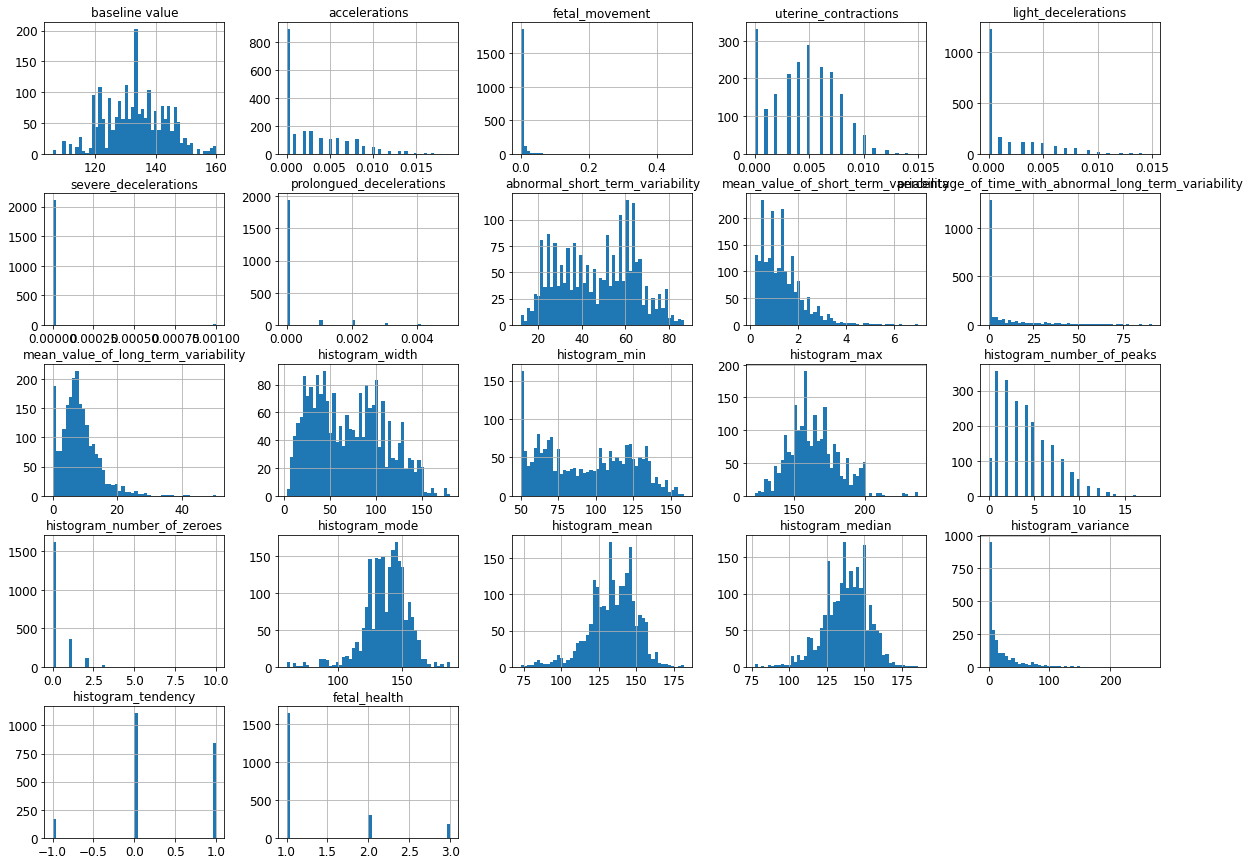

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fetal.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
asdf = fetal.copy()
helthybois = asdf["fetal_health"]
acc = len(helthybois[helthybois==1])/len(helthybois)
print(acc)


0.7784571966133584


In [ ]:
# split into training and testing dataset
train_set, test_set = train_test_split(fetal, test_size=0.2, random_state=42)
print(train_set.shape )
print(test_set.shape )

(1700, 22)
(426, 22)


In [ ]:
train_label = train_set['fetal_health'].copy()
train_set = train_set.drop(["fetal_health"], axis=1)
test_label = test_set['fetal_health'].copy()
test_set = test_set.drop(["fetal_health"], axis=1)

In [ ]:
# pipeline for transforming the numeric variables
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

In [ ]:
# pipeline for transforming the entire dataset
# in this case, we only have numeric variables in our dataset.

num_attribs = list(train_set)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
    ])


In [ ]:
# transform the train_set and test_set
train_prepared = full_pipeline.fit_transform(train_set)
test_prepared = full_pipeline.transform(test_set)
print(train_prepared.shape)
print(test_prepared.shape)

(1700, 21)
(426, 21)


In [ ]:
# train_prepared --> training set features
# train_label --> training set labels
# test_prepared
# test_label

# Classification


**We'll start by trying the ensemble learning model for classification:** 
> This model will use several different classifiers and allow them to vote in order to classify an entry. Our classifiers will be Random Forest Classifier, Support Vector Machine, and Logistic Regression. 




In [ ]:
# We make the appropriate imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# We are creating the model for each classifier
log_clf = LogisticRegression(solver="lbfgs", random_state=32)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=32)
svm_clf = SVC(gamma="scale", probability=True, random_state=32)

# We are creating the ensemble classifier that uses all the above classifiers
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')


In this next section, we are looking at the accuracy on predictions of each classifier individually and the ensemble classifier. So we begin by defining a function to report scoring metrics.

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np

def clf_scores(y_actual, y_predict):
  conf = confusion_matrix(y_actual, y_predict) # get confusion matrix
  print("Confusion Matrix:\n", conf)
  recall = np.diagonal(conf) / (np.sum(conf,axis=1)) # recall of each class
  precision = np.diagonal(conf) / (np.sum(conf,axis=0)) # precision of each class
  f1 = 2*recall*precision / (precision + recall) 
  print("Precision:\n", precision, "\nRecall:\n", recall, "\nF1 Score:\n", f1, "\n")
  return conf, recall, precision, f1

In [ ]:
from sklearn.metrics import accuracy_score

# Train each model
print("Scoring Metrics for each Model:\n")
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(train_prepared, train_label)
    y_pred = clf.predict(test_prepared)
    print(clf.__class__.__name__, accuracy_score(test_label, y_pred))
    clf_scores(test_label, y_pred)

Scoring Metrics for each Model:

LogisticRegression 0.8779342723004695
Confusion Matrix:
 [[311  19   3]
 [ 18  41   5]
 [  2   5  22]]
Precision:
 [0.93957704 0.63076923 0.73333333] 
Recall:
 [0.93393393 0.640625   0.75862069] 
F1 Score:
 [0.93674699 0.63565891 0.74576271] 

RandomForestClassifier 0.9507042253521126
Confusion Matrix:
 [[327   5   1]
 [ 10  52   2]
 [  1   2  26]]
Precision:
 [0.96745562 0.88135593 0.89655172] 
Recall:
 [0.98198198 0.8125     0.89655172] 
F1 Score:
 [0.97466468 0.84552846 0.89655172] 

SVC 0.903755868544601
Confusion Matrix:
 [[317  15   1]
 [ 17  46   1]
 [  2   5  22]]
Precision:
 [0.94345238 0.6969697  0.91666667] 
Recall:
 [0.95195195 0.71875    0.75862069] 
F1 Score:
 [0.94768311 0.70769231 0.83018868] 

VotingClassifier 0.9272300469483568
Confusion Matrix:
 [[322  11   0]
 [ 13  49   2]
 [  1   4  24]]
Precision:
 [0.95833333 0.765625   0.92307692] 
Recall:
 [0.96696697 0.765625   0.82758621] 
F1 Score:
 [0.96263079 0.765625   0.87272727] 



We observe that the individual Random Forest Classifier is better than every other model as well as the Voting Classifier

**Now we will try another powerful method: AdaBoosting**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# We create the AdaBoost Classifier using Decision Tree
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=32)

# Train on the data
ada_clf.fit(train_prepared, train_label)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [ ]:
# Looking at accuracy of model
y_pred = ada_clf.predict(test_prepared)
print("Accuracy of Decision Tree Boosting: " + str(accuracy_score(test_label, y_pred)))
clf_scores(test_label, y_pred);

Accuracy of Decision Tree Boosting: 0.9061032863849765
Confusion Matrix:
 [[319  13   1]
 [ 17  46   1]
 [  8   0  21]]
Precision:
 [0.92732558 0.77966102 0.91304348] 
Recall:
 [0.95795796 0.71875    0.72413793] 
F1 Score:
 [0.94239291 0.74796748 0.80769231] 



**It seems that singular Random-Forest Classifier outperforms all the other models. We will proceed with it and further optimize.**

# Optimization

##New Scoring Function for Optimization.

We begin by creating our own loss function for grid search to look for. Finding the best model is dependent on how "best" is defined. As our project concerns medical health, we insist that the recall must be high so that if fetal health is poor, it will not go undetected. We do not want any false negatives on the poor health classifiers. At the same time, however, we cannot let precision drop too low, so we define our new scoring function to be similar to the F1 score, but with more weight given to recall. The F1 formula is f1 = 2 / ( 1/p + 1/r ) for precision p and recall r. We define our unique scoring function:\
f2 = ( 1 + a ) / ( 1/p + a*1/r ) \
which is the same as the f1 metric but with weight "a" applied to the recall term, so that recall will be made more important than precision for a > 1. Additionally, the precision and recall used in these formulas can be a weighted average of the recalls for each class, with more weight given to the unhealthy class.The f2 score will always be between 0 and 1 if the weight vector is normalized such that the components sum to 1.

In [ ]:
from sklearn.metrics import make_scorer

def f2(y, y_pred, **kwargs):
  a = 2 # adjust this for recall weight
  weights = np.array([1,1,2]) # adjust this for recall weight on each class
  weights = weights / np.sum(weights) # normalize weights; weights for direction, a for magnitude

  conf = confusion_matrix(y, y_pred) # get confusion matrix
  recall = np.diagonal(conf) / (np.sum(conf,axis=1)) # recall scores for each class
  precision = np.diagonal(conf) / (np.sum(conf,axis=0)) # precision scores for each class

  r = np.dot(weights, recall)  # weighted recall average
  p = np.mean(precision) # precision average
  f2 = ( 1 + a ) / ( 1/p + a*1/r ) # f2 formula
  return f2

f2_score = make_scorer(f2, greater_is_better=True)


##Random and Grid Searching Hyperparameters.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

forest_clf = RandomForestClassifier(random_state=32)

param_dist = {'n_estimators': randint(1,1000),
              'min_samples_split': randint(2,10),
              'max_depth': randint(1,250),
              'min_samples_leaf': randint(1,10),
              'max_features': randint(1,22),
              'max_leaf_nodes': randint(2,500)
              }
n_iter_search = 100

random_search = RandomizedSearchCV(forest_clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, scoring=f2_score)

random_search.fit(train_prepared, train_label)

cvres = random_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(mean_score, params)

print("Best: ", random_search.best_params_)


In [ ]:
from sklearn.model_selection import GridSearchCV
forest_clf = RandomForestClassifier(random_state=32)

param_grid = {'n_estimators': range(200, 350, 25),
              'min_samples_split': range(3,12,3),
              'max_depth': range(80,120,20),
              'min_samples_leaf': range(1,3),
              'max_features': range(6,16,2),
              'max_leaf_nodes': range(100,200,50)
              }

grid_search = GridSearchCV(forest_clf, param_grid, cv=5, 
                           scoring = f2_score, return_train_score=True)

grid_search.fit(train_prepared, train_label)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  if mean_score > 1.2:
    print(mean_score, params)

print("Best Parameters: ", grid_search.best_params_)

1.204135820272366 {'max_depth': 80, 'max_features': 6, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}
1.2034224753253544 {'max_depth': 80, 'max_features': 6, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 225}
1.203743054220356 {'max_depth': 80, 'max_features': 6, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 250}
1.2057311577073557 {'max_depth': 80, 'max_features': 6, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 275}
1.2049631796622875 {'max_depth': 80, 'max_features': 6, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 300}
1.2057897844075849 {'max_depth': 80, 'max_features': 6, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 325}
1.201308736286034 {'max_depth': 80, 'max_features': 6, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'min_samples_split'

##Best Model.

In [ ]:
forest_clf = RandomForestClassifier(max_depth= 80, max_features= 8, max_leaf_nodes= 100, min_samples_leaf= 2, min_samples_split= 3, n_estimators= 325, random_state=32)

forest_clf.fit(train_prepared, train_label)

y_pred = forest_clf.predict(test_prepared)
print("Random Forest Accuracy: ", accuracy_score(test_label, y_pred))
clf_scores(test_label, y_pred);

Random Forest Accuracy:  0.9507042253521126
Confusion Matrix:
 [[325   6   2]
 [ 10  53   1]
 [  1   1  27]]
Precision:
 [0.9672619  0.88333333 0.9       ] 
Recall:
 [0.97597598 0.828125   0.93103448] 
F1 Score:
 [0.9715994  0.85483871 0.91525424] 



We see that this model has indeed achieved a greater recall for class 3 than for any other class. The weights of the f2 scoring function may also be adjusted to increase this recall even further, but at the loss of precision.

# ANN 

Let's relabel the data to be 0, 1, or 2 instead of 1, 2, or 3. This is because the ANN will end with a dense 3 layer using softmax activation, so it will automatically assume values are 0, 1, or 2.

In [ ]:
from keras.utils.np_utils import to_categorical   

ann_train_labels = train_label-1 #012 instead of 123
ann_test_labels = test_label-1
print(ann_train_labels.shape, ann_test_labels.shape)



(1700,) (426,)


Let's make a function to create a nueral net, this way it can be passed to a gridsearch function.

In [ ]:
import tensorflow as tf
from tensorflow import keras

def SM(ns=[128], ACTs=['relu'], dws=[0.2], opt = keras.optimizers.Nadam()):
        if len(ns)!= len(ACTs) or len(ACTs) != len(dws):
          print("input list lengths must be equal")
          return

        model = keras.models.Sequential()
        model.add(keras.layers.Flatten(input_shape=[21]))

        for i in range(len(ns)):
          model.add(keras.layers.Dense(ns[i], activation=ACTs[i]))
          if dws[i]==0: pass
          model.add(keras.layers.Dropout(dws[i]))    

        model.add(keras.layers.Dense(3, activation='softmax'))

        model.compile(optimizer=opt,loss="sparse_categorical_crossentropy", metrics=['accuracy'])
        return model

Gridsearch time! Note the metric being used is the f2 score, our function defined above to maximize recall for the pathological class.




In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

model = KerasClassifier(build_fn=SM, epochs = 50, verbose=0)

pipe = Pipeline([
    ('model', model)
])


param_grid = dict(ns = [(768,768,768),(256,256,256),(512,512,512)],
                  ACTs=[('relu','relu','relu')], 
                  dws = [(0.0,0.0,0.0),(0.0,0.3, 0.3),(0.2,0.2, 0.2),(0.0,0.1, 0.3), (0.3,0.1,0)],
                  epochs = [25, 50,75])

grid = GridSearchCV(estimator = model, param_grid=param_grid, cv=5, scoring=f2_score, return_train_score=True)
grid_result = grid.fit(train_prepared, ann_train_labels)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Best: 0.884211 using {'ACTs': ('relu', 'relu', 'relu'), 'dws': (0.2, 0.2, 0.2), 'epochs': 25, 'ns': (512, 512, 512)}


Let's print the scores so we can get an idea of how different parameters impact the f2 score.

In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.847582 (0.051272) with: {'ACTs': ('relu', 'relu', 'relu'), 'dws': (0.0, 0.0, 0.0), 'epochs': 25, 'ns': (768, 768, 768)}
0.841998 (0.052827) with: {'ACTs': ('relu', 'relu', 'relu'), 'dws': (0.0, 0.0, 0.0), 'epochs': 25, 'ns': (256, 256, 256)}
0.845753 (0.032541) with: {'ACTs': ('relu', 'relu', 'relu'), 'dws': (0.0, 0.0, 0.0), 'epochs': 25, 'ns': (512, 512, 512)}
0.858646 (0.033205) with: {'ACTs': ('relu', 'relu', 'relu'), 'dws': (0.0, 0.0, 0.0), 'epochs': 50, 'ns': (768, 768, 768)}
0.841205 (0.036336) with: {'ACTs': ('relu', 'relu', 'relu'), 'dws': (0.0, 0.0, 0.0), 'epochs': 50, 'ns': (256, 256, 256)}
0.842881 (0.049662) with: {'ACTs': ('relu', 'relu', 'relu'), 'dws': (0.0, 0.0, 0.0), 'epochs': 50, 'ns': (512, 512, 512)}
0.843027 (0.049944) with: {'ACTs': ('relu', 'relu', 'relu'), 'dws': (0.0, 0.0, 0.0), 'epochs': 75, 'ns': (768, 768, 768)}
0.867910 (0.028214) with: {'ACTs': ('relu', 'relu', 'relu'), 'dws': (0.0, 0.0, 0.0), 'epochs': 75, 'ns': (256, 256, 256)}
0.849350 (0.039256) with

Now we use our overall score function to report how well our model did.

In [ ]:
model = grid_result.best_estimator_
pred =model.predict(test_prepared)
clf_scores(ann_test_label, pred);

Confusion Matrix:
 [[319  13   1]
 [  8  51   5]
 [  0   2  27]]
Precision:
 [0.97553517 0.77272727 0.81818182] 
Recall:
 [0.95795796 0.796875   0.93103448] 
F1 Score:
 [0.96666667 0.78461538 0.87096774] 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Let's make our final model below.

In [ ]:
model = SM(ns=[512,512,512], ACTs=['relu','relu','relu'], dws=[0.2,0.2,0.2])

checkpoint_filepath = 'ANN.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(train_prepared[:-200], ann_train_labels[:-200], 
                    validation_data=(train_prepared[-200:], ann_train_labels[-200:]),
                    epochs=25, callbacks=[model_checkpoint_callback]) 

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

pred = np.argmax(model.predict(test_prepared), axis = 1)
clf_scores(ann_test_labels, pred);


Epoch 1/25
47/47 [==============================] - 2s 21ms/step - loss: 0.9346 - accuracy: 0.7313 - val_loss: 0.2345 - val_accuracy: 0.8700
Epoch 2/25
47/47 [==============================] - 1s 16ms/step - loss: 0.2487 - accuracy: 0.8945 - val_loss: 0.2872 - val_accuracy: 0.9000
Epoch 3/25
47/47 [==============================] - 1s 16ms/step - loss: 0.2176 - accuracy: 0.8962 - val_loss: 0.2166 - val_accuracy: 0.8700
Epoch 4/25
47/47 [==============================] - 1s 16ms/step - loss: 0.2024 - accuracy: 0.9127 - val_loss: 0.2151 - val_accuracy: 0.9250
Epoch 5/25
47/47 [==============================] - 1s 18ms/step - loss: 0.1863 - accuracy: 0.9211 - val_loss: 0.2167 - val_accuracy: 0.9250
Epoch 6/25
47/47 [==============================] - 1s 18ms/step - loss: 0.1588 - accuracy: 0.9317 - val_loss: 0.2218 - val_accuracy: 0.9150
Epoch 7/25
47/47 [==============================] - 1s 16ms/step - loss: 0.1481 - accuracy: 0.9290 - val_loss: 0.2582 - val_accuracy: 0.9250
Epoch 8/25
47

In [ ]:
pred = np.argmax(model.predict(test_prepared), axis = 1)
print("ANN Accuracy: ", accuracy_score(test_label, y_pred))
clf_scores(ann_test_labels, pred);

ANN Accuracy:  0.9507042253521126
Confusion Matrix:
 [[319  13   1]
 [ 14  47   3]
 [  1   2  26]]
Precision:
 [0.95508982 0.75806452 0.86666667] 
Recall:
 [0.95795796 0.734375   0.89655172] 
F1 Score:
 [0.95652174 0.74603175 0.88135593] 



In [ ]:
model.save('ML4VA_ANN')

INFO:tensorflow:Assets written to: ML4VA_ANN/assets


NEXT STEPS:
bagging/ensemble?
remember to train final model with all data after testing.